<a href="https://colab.research.google.com/github/YoheiMurata/moomoo-lab.keras/blob/master/DCGAN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10画像の生成をDCGANで実装しよう
DCGANの実装をして、試しに学習・生成をしてみます。
教師用データは、クラス分類用のデータセットであるCIFAR-10を利用します。

大きな流れとしては、下記の通りです。


1.   教師用データを作成
2.   ネットワークを作成
3.   ネットワークを学習・重みを保存
4.   試しに生成



In [1]:
import keras
from keras import Sequential, Model
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import BatchNormalization, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Activation
from keras.layers import Flatten, Dense, Input, Reshape
from keras.initializers import RandomNormal as RN
from keras.datasets import cifar10
from keras.optimizers import Adam
import numpy as np

from tqdm import tqdm

Using TensorFlow backend.


In [0]:
# データセット作成に必要なライブラリのインポート
from google.colab import drive
import os
import sys
import glob
from PIL import Image
import datetime
import matplotlib.pyplot as plt

Google Driveをマウントします

In [3]:
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


CIFAR-10のラベル情報は0~9の10種類があり、それぞれの数字が飛行機、猫などを表しています

In [0]:
IDX_AIRPLANE = 0
IDX_CAR = 1
IDX_BIRD = 2
IDX_CAT = 3
IDX_COW = 4
IDX_DOG = 5
IDX_FROG = 6
IDX_HOURSE = 7
IDX_SHIP = 8
IDX_TRUCK = 9

# データセットの作成
CIFAR-10の特定画像を抽出してデータセットを生成します
ここでは、例として猫（IDX_CAT）を抽出します

In [0]:
'''
指定したディレクトリにデータセット化した猫画像を
指定した場所に出力する
-----
引数:
  output_path: データセット出力先のファイルパス
'''
def make_dataset(output_path):
  # CIFAR-10をダウンんロードします
  (x_train, y_train), (_, _) = cifar10.load_data()
  # 猫画像を抽出します
  idxs = np.where( y_train == IDX_CAT )[0]
  datas = x_train[ idxs ]
  datas = datas.reshape( len( idxs ), 32, 32, 3 )
  # 画像の各ピクセルの値が-1~1の範囲となるように正規化します
  datas = ( datas.astype( np.float32 ) - 127.5 ) / 127.5

  # ディレクトリが存在しない場合は作成してデータセットを出力します
  if not os.path.exists( output_path ):
    os.mkdir( output_path )
  dataset = np.array( datas, dtype = np.float32 )
  # ファイル名「datasets.npz」でデータセットを保存します
  np.savez( output_path + 'datasets.npz', X = dataset )


In [7]:
# Google Drive上に「dcgan_test」フォルダを作成してデータセットを保存します
make_dataset('drive/My Drive/dcgan_test/')

170500096/170498071 [==============================] - 6s 0us/step


保存したデータセットをロードして、変数Xに格納します

In [0]:
datas = np.load('drive/My Drive/dcgan_test/datasets.npz')
X = datas['X']

試しに1枚だけ適当に表示してみます

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


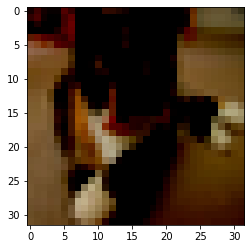

In [9]:
plt.imshow(X[190])

# DCGANモデルの定義
潜在変数の次元数はひとまず１００として、生成者、識別者のモデルを定義していきます


In [0]:
# 潜在変数の定義
noise_dim = 100

In [0]:
'''
生成者の作成
'''
def make_generator():
  model = Sequential()

  # 1つ目のブロック（ベクトルから4x4の画像に）
  model.add( Dense( 1024, input_shape = ( noise_dim, ) ) )
  model.add( LeakyReLU() )
  model.add( Dropout( 0.3 ) )
  model.add( Dense( 4 * 4 * 512 ) )
  model.add( BatchNormalization() )
  model.add( LeakyReLU() )
  model.add( Reshape( ( 4, 4, 512 ) ) )

  # 2つ目のブロック（4x4の画像から8x8の画像に）
  model.add( Conv2DTranspose( filters = 256, kernel_size = 5, strides = 2, padding = 'same', kernel_initializer=RN(mean=0.0, stddev=0.02) ) )
  model.add( BatchNormalization() )
  model.add( LeakyReLU() )
  model.add( Conv2D( filters = 256, kernel_size = 2, padding = 'same', kernel_initializer=RN(mean=0.0, stddev=0.02)  ) )
  model.add( BatchNormalization() )
  model.add( LeakyReLU() )

  # 3つ目のブロック（8x8の画像から16x16の画像に）
  model.add( Conv2DTranspose( filters = 128, kernel_size = 5, strides = 2, padding = 'same', kernel_initializer=RN(mean=0.0, stddev=0.02)  ) )
  model.add( BatchNormalization() )
  model.add( LeakyReLU() )

  # 4つ目のブロック（１６x１６の画像から３２x３２の画像に）
  model.add( Conv2DTranspose( filters = 3, kernel_size = 5, strides = 2, padding = 'same', kernel_initializer=RN(mean=0.0, stddev=0.02)  ) )
  model.add( BatchNormalization() )
  model.add( Activation('tanh') )

  return model



In [0]:
'''
識別者の作成
'''
def make_discriminator():
  model = Sequential()

  # 1つ目のブロック
  model.add( Conv2D( filters = 32, kernel_size = 5, strides = 2, input_shape = ( 32, 32, 3 ), padding = 'same', kernel_initializer=RN(mean=0.0, stddev=0.02) ) )
  model.add( BatchNormalization() )
  model.add( Activation('relu') )

  # 2つ目のブロック
  model.add( Conv2D( filters = 64, kernel_size = 5, strides = 2, padding = 'same', kernel_initializer=RN(mean=0.0, stddev=0.02) ) )
  model.add( BatchNormalization() )
  model.add( Activation('relu') )

  # 3つ目のブロック
  model.add( Conv2D( filters = 128, kernel_size = 5, strides = 2, padding = 'same', kernel_initializer=RN(mean=0.0, stddev=0.02) ) )
  model.add( Activation('relu') )
  model.add( Flatten() )
  model.add( Dropout( 0.5 ) )
  model.add( Dense( 64 ))
  model.add( Dense( 1, activation = 'sigmoid' ) )

  return model

次の関数は、Combinedネットワークの作成をします。
Combinedは生成者と識別者を組み合わせたネットワークで、生成者の学習に利用します。
生成者が学習している間、識別者は学習しないよう、trainableをFalseに設定します

In [0]:
'''
Combinedの作成
Combinedは、generatorを学習する用のネットワークのこと
'''
def make_combined( generator, discriminator ):
  # trainable = Falseで識別者の学習を止めます
  discriminator.trainable = False

  model = Sequential( [ generator, discriminator ] )

  return model

生成者が生成した画像を保存する関数を定義します。
1枚の画像の中に、25枚生成画像を５x５に並べて生成します

In [0]:
'''
生成した画像の表示と保存
'''
FAKE_IMAGE_PATH = 'drive/My Drive/dcgan_test/genImage/'
def saveImage( iteration, noise ):
  fig, axes = plt.subplots( 5, 5 )
  images = generator.predict( noise )
  images = images * 127.5 + 127.5
  images = images.astype( np.int32 )

  for img, ax in zip( images, axes.flatten() ):
    ax.imshow( img )
    ax.axis('off')
  
  if not os.path.exists(FAKE_IMAGE_PATH):
    os.mkdir(FAKE_IMAGE_PATH)

  fname = FAKE_IMAGE_PATH + 'generate_%05d.png' % iteration
  fig.savefig( fname )

  plt.close()


# DCGANモデルを学習
モデルを実際に学習させます。for文のなかで、識別者、生成者の順番で学習をさせます

In [0]:
'''
モデルの作成と学習を始める
'''
generator = make_generator()

discriminator = make_discriminator()

# discriminatorをコンパイルする
discriminator.trainable = True
discriminator.compile( loss = 'binary_crossentropy', optimizer = Adam( lr = 0.0002, beta_1 = 0.5 ), metrics = [ 'accuracy' ] )


# combinedをコンパイルする
combined = make_combined( generator, discriminator )
combined.compile( loss = 'binary_crossentropy', optimizer = Adam( lr = 0.0002, beta_1 = 0.5 ), metrics = [ 'accuracy' ] )
combined.summary()
# チェックポイントで出力させる用の潜在変数を生成しておきます
checkPointNoise = np.random.uniform( -1, 1, ( 25, noise_dim ) )

iteration = 50000
batch_size = 300 #1回あたりの学習回数
checkpoint = 500 #ここの回数ごとに画像を生成して記録します

try:

  for i in tqdm( range( iteration ) ):  
    # 画像をランダムに選んで教師データとします
    idx = np.random.randint( 0, len( X ), batch_size )

    realImages = X[ idx ]
    realImages = realImages.reshape( batch_size, 32, 32, 3 )
　　　　　　　# 
    noise = np.random.uniform( -1, 1, size = ( batch_size, noise_dim ) )

    generatedImages = generator.predict( noise )

    d_loss_real = discriminator.train_on_batch( realImages, np.ones( ( batch_size, 1 ) ) )
    d_loss_fake = discriminator.train_on_batch( generatedImages, np.zeros( ( batch_size, 1 ) ) )
    d_loss = 0.5 * np.add( d_loss_real, d_loss_fake ) 

    noise = np.random.uniform( -1, 1, size = ( batch_size, noise_dim ) )
    g_loss = combined.train_on_batch( noise, np.ones( ( batch_size, 1 ) ) )

    if i % checkpoint == 0:
      saveImage( i, checkPointNoise )
      print('d_loss_real = {}, d_loss_fake = {}, g_loss = {}'.format(d_loss_real[0], d_loss_fake[0], g_loss[0]))

except Exception as e:
  print(e)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


  0%|          | 0/50000 [00:00<?, ?it/s]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 32, 32, 3)         12903951  
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 390209    
Total params: 13,294,160
Trainable params: 12,886,281
Non-trainable params: 407,879
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  0%|          | 1/50000 [00:11<166:15:38, 11.97s/it]/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  0%|          | 2/50000 [00:12<116:54:17,  8.42s/it]

d_loss_real = 0.9471014142036438, d_loss_fake = 1.023795247077942, g_loss = 0.21501775085926056


  1%|          | 502/50000 [01:14<3:42:28,  3.71it/s]

d_loss_real = 0.005136944819241762, d_loss_fake = 0.0029678901191800833, g_loss = 0.008910189382731915


  2%|▏         | 1002/50000 [02:17<3:52:50,  3.51it/s]

d_loss_real = 0.004384032916277647, d_loss_fake = 0.01470707543194294, g_loss = 0.013547123409807682


  3%|▎         | 1502/50000 [03:19<3:26:40,  3.91it/s]

d_loss_real = 0.0008374778553843498, d_loss_fake = 0.0017176338005810976, g_loss = 0.001466355170123279


  4%|▍         | 2002/50000 [04:21<3:19:11,  4.02it/s]

d_loss_real = 0.012790404260158539, d_loss_fake = 0.015352689661085606, g_loss = 0.014920704998075962


  5%|▌         | 2502/50000 [05:23<3:18:11,  3.99it/s]

d_loss_real = 0.012337795458734035, d_loss_fake = 0.059713706374168396, g_loss = 0.01723533496260643


  6%|▌         | 3002/50000 [06:26<3:47:33,  3.44it/s]

d_loss_real = 0.0023015590850263834, d_loss_fake = 0.0034712215419858694, g_loss = 0.0039442493580281734


  7%|▋         | 3502/50000 [07:28<3:13:30,  4.00it/s]

d_loss_real = 0.003867147723212838, d_loss_fake = 0.0001865080848801881, g_loss = 0.0021947650238871574


  8%|▊         | 4002/50000 [08:30<3:17:09,  3.89it/s]

d_loss_real = 0.0077763707377016544, d_loss_fake = 0.002433066489174962, g_loss = 0.005583203863352537


  9%|▉         | 4502/50000 [09:31<3:08:21,  4.03it/s]

d_loss_real = 0.14077328145503998, d_loss_fake = 0.018853891640901566, g_loss = 0.00019671153859235346


 10%|█         | 5002/50000 [10:33<3:54:46,  3.19it/s]

d_loss_real = 0.002722938545048237, d_loss_fake = 0.0009742174297571182, g_loss = 0.009767726063728333


 11%|█         | 5502/50000 [11:36<3:10:54,  3.88it/s]

d_loss_real = 0.005251257214695215, d_loss_fake = 0.002492928644642234, g_loss = 0.004502603318542242


 12%|█▏        | 6002/50000 [12:39<3:09:34,  3.87it/s]

d_loss_real = 0.0469098836183548, d_loss_fake = 0.004983759485185146, g_loss = 0.003803952829912305


 13%|█▎        | 6502/50000 [13:42<3:12:41,  3.76it/s]

d_loss_real = 0.014978421851992607, d_loss_fake = 0.0014493223279714584, g_loss = 0.009814325720071793


 14%|█▍        | 7002/50000 [14:45<3:02:54,  3.92it/s]

d_loss_real = 0.010835375636816025, d_loss_fake = 4.244683441356756e-05, g_loss = 0.4251693785190582


 15%|█▌        | 7502/50000 [15:47<4:00:59,  2.94it/s]

d_loss_real = 0.19534125924110413, d_loss_fake = 0.07288536429405212, g_loss = 0.003364340402185917


 16%|█▌        | 8002/50000 [16:50<2:58:19,  3.93it/s]

d_loss_real = 0.002924226922914386, d_loss_fake = 0.00018100507440976799, g_loss = 0.003614303655922413


 17%|█▋        | 8502/50000 [17:52<2:51:05,  4.04it/s]

d_loss_real = 1.3771047592163086, d_loss_fake = 1.482761025428772, g_loss = 0.0514054000377655


 18%|█▊        | 9002/50000 [18:53<2:51:18,  3.99it/s]

d_loss_real = 0.06750667840242386, d_loss_fake = 0.03857703134417534, g_loss = 0.015384291298687458


 19%|█▉        | 9502/50000 [19:55<2:53:18,  3.89it/s]

d_loss_real = 0.12659533321857452, d_loss_fake = 0.0003762104024644941, g_loss = 0.0639277920126915


 20%|██        | 10002/50000 [20:56<2:49:25,  3.93it/s]

d_loss_real = 0.020080506801605225, d_loss_fake = 0.000545529299415648, g_loss = 0.006068564020097256


 21%|██        | 10502/50000 [21:57<2:38:07,  4.16it/s]

d_loss_real = 0.002552805468440056, d_loss_fake = 4.255817839293741e-05, g_loss = 0.00374717079102993


 22%|██▏       | 11002/50000 [22:58<3:48:59,  2.84it/s]

d_loss_real = 0.004126803483814001, d_loss_fake = 0.007956506684422493, g_loss = 0.00522001925855875


 23%|██▎       | 11502/50000 [23:59<2:44:46,  3.89it/s]

d_loss_real = 0.0031702255364507437, d_loss_fake = 0.0017112285131588578, g_loss = 0.00296033569611609


 24%|██▍       | 12002/50000 [25:01<2:50:37,  3.71it/s]

d_loss_real = 0.007162482012063265, d_loss_fake = 8.486789010930806e-05, g_loss = 0.009059884585440159


 25%|██▌       | 12502/50000 [26:03<2:33:53,  4.06it/s]

d_loss_real = 0.05213695764541626, d_loss_fake = 0.07630790770053864, g_loss = 0.09864861518144608


 26%|██▌       | 13002/50000 [27:06<4:40:03,  2.20it/s]

d_loss_real = 0.04349908232688904, d_loss_fake = 0.010341016575694084, g_loss = 0.026754135265946388


 27%|██▋       | 13502/50000 [28:08<2:31:37,  4.01it/s]

d_loss_real = 0.2368640899658203, d_loss_fake = 0.3696371018886566, g_loss = 0.06968925893306732


 28%|██▊       | 14002/50000 [29:10<2:30:22,  3.99it/s]

d_loss_real = 0.10701431334018707, d_loss_fake = 0.001174562145024538, g_loss = 0.020318515598773956


 29%|██▉       | 14502/50000 [30:12<2:25:24,  4.07it/s]

d_loss_real = 0.037800487130880356, d_loss_fake = 0.13515299558639526, g_loss = 0.04940395802259445


 30%|███       | 15002/50000 [31:15<3:39:30,  2.66it/s]

d_loss_real = 0.20921659469604492, d_loss_fake = 0.0018516886048018932, g_loss = 0.2403809130191803


 31%|███       | 15502/50000 [32:16<2:25:35,  3.95it/s]

d_loss_real = 0.04698587954044342, d_loss_fake = 0.0037550413981080055, g_loss = 0.030499953776597977


 32%|███▏      | 16002/50000 [33:17<2:26:03,  3.88it/s]

d_loss_real = 0.14289571344852448, d_loss_fake = 0.0134429931640625, g_loss = 0.6159259676933289


 33%|███▎      | 16502/50000 [34:19<2:19:42,  4.00it/s]

d_loss_real = 0.16299857199192047, d_loss_fake = 0.0007858761237002909, g_loss = 0.11763286590576172


 34%|███▍      | 17002/50000 [35:20<2:21:13,  3.89it/s]

d_loss_real = 0.00672850850969553, d_loss_fake = 0.0009672338492237031, g_loss = 0.006060094106942415


 35%|███▌      | 17502/50000 [36:22<2:15:49,  3.99it/s]

d_loss_real = 2.7160897254943848, d_loss_fake = 0.5829223394393921, g_loss = 0.04432911053299904


 36%|███▌      | 18002/50000 [37:24<2:48:29,  3.17it/s]

d_loss_real = 0.00637234840542078, d_loss_fake = 0.06872629374265671, g_loss = 0.010282063856720924


 37%|███▋      | 18502/50000 [38:26<2:11:39,  3.99it/s]

d_loss_real = 0.014566030353307724, d_loss_fake = 0.00013634537754114717, g_loss = 0.01780271716415882


 38%|███▊      | 19002/50000 [39:27<2:11:27,  3.93it/s]

d_loss_real = 0.0048948023468256, d_loss_fake = 0.021198900416493416, g_loss = 0.009489903226494789


 39%|███▉      | 19502/50000 [40:29<2:11:41,  3.86it/s]

d_loss_real = 0.02074386551976204, d_loss_fake = 0.0071469019167125225, g_loss = 0.00776786869391799


 40%|████      | 20002/50000 [41:31<3:28:44,  2.40it/s]

d_loss_real = 0.1729002594947815, d_loss_fake = 0.03916741535067558, g_loss = 0.024485517293214798


 41%|████      | 20502/50000 [42:33<2:06:40,  3.88it/s]

d_loss_real = 0.1584467589855194, d_loss_fake = 0.013670948334038258, g_loss = 0.008124358020722866


 42%|████▏     | 21002/50000 [43:35<2:01:28,  3.98it/s]

d_loss_real = 0.03615891933441162, d_loss_fake = 0.023523343726992607, g_loss = 0.03752048313617706


 43%|████▎     | 21502/50000 [44:36<2:07:48,  3.72it/s]

d_loss_real = 0.027706604450941086, d_loss_fake = 0.005074505228549242, g_loss = 0.0023652431555092335


 44%|████▍     | 22002/50000 [45:38<1:57:35,  3.97it/s]

d_loss_real = 0.00522117642685771, d_loss_fake = 0.038341689854860306, g_loss = 0.009470474906265736


 45%|████▌     | 22502/50000 [46:40<1:53:09,  4.05it/s]

d_loss_real = 0.0032883433159440756, d_loss_fake = 0.0009566113585606217, g_loss = 0.010965048335492611


 46%|████▌     | 23002/50000 [47:41<1:52:49,  3.99it/s]

d_loss_real = 0.004685318563133478, d_loss_fake = 4.379217716632411e-05, g_loss = 0.007865995168685913


 47%|████▋     | 23502/50000 [48:43<1:50:42,  3.99it/s]

d_loss_real = 0.0034046261571347713, d_loss_fake = 0.00010670120536815375, g_loss = 0.004526028875261545


 48%|████▊     | 24002/50000 [49:44<1:54:00,  3.80it/s]

d_loss_real = 0.02838021330535412, d_loss_fake = 0.004530441481620073, g_loss = 0.042732320725917816


 49%|████▉     | 24502/50000 [50:45<1:44:22,  4.07it/s]

d_loss_real = 0.03142299875617027, d_loss_fake = 0.009809915907680988, g_loss = 0.09961628168821335


 50%|█████     | 25002/50000 [51:47<1:46:47,  3.90it/s]

d_loss_real = 0.02761228196322918, d_loss_fake = 0.01237709540873766, g_loss = 0.06866093724966049


 51%|█████     | 25502/50000 [52:48<1:46:49,  3.82it/s]

d_loss_real = 0.04106159508228302, d_loss_fake = 0.00016389529628213495, g_loss = 0.060609232634305954


 52%|█████▏    | 26002/50000 [53:50<2:16:27,  2.93it/s]

d_loss_real = 0.009601148776710033, d_loss_fake = 4.00697608711198e-05, g_loss = 0.00811510905623436


 53%|█████▎    | 26502/50000 [54:53<3:17:14,  1.99it/s]

d_loss_real = 0.0058676558546721935, d_loss_fake = 0.011198865249752998, g_loss = 0.007093728985637426


 54%|█████▍    | 27002/50000 [55:54<1:25:19,  4.49it/s]

d_loss_real = 0.11123385280370712, d_loss_fake = 0.027297649532556534, g_loss = 0.1880090981721878


 55%|█████▌    | 27502/50000 [56:55<1:34:41,  3.96it/s]

d_loss_real = 0.5237417221069336, d_loss_fake = 0.4076734483242035, g_loss = 0.002761121140792966


 56%|█████▌    | 28002/50000 [57:57<1:27:08,  4.21it/s]

d_loss_real = 0.02130436897277832, d_loss_fake = 0.002599806059151888, g_loss = 0.02637249231338501


 57%|█████▋    | 28502/50000 [58:58<1:28:12,  4.06it/s]

d_loss_real = 0.039483655244112015, d_loss_fake = 0.06856205314397812, g_loss = 0.03520692139863968


 58%|█████▊    | 29002/50000 [1:00:00<1:20:36,  4.34it/s]

d_loss_real = 0.37677839398384094, d_loss_fake = 0.002678260672837496, g_loss = 0.33248552680015564


 59%|█████▉    | 29502/50000 [1:01:02<1:18:55,  4.33it/s]

d_loss_real = 0.0012010018108412623, d_loss_fake = 0.00047156523214653134, g_loss = 0.0028772077057510614


 60%|██████    | 30002/50000 [1:02:04<1:17:14,  4.32it/s]

d_loss_real = 0.008198865689337254, d_loss_fake = 0.2165873944759369, g_loss = 0.002688542939722538


 61%|██████    | 30502/50000 [1:03:05<1:14:46,  4.35it/s]

d_loss_real = 0.12414971739053726, d_loss_fake = 0.016833152621984482, g_loss = 0.03799451142549515


 62%|██████▏   | 31002/50000 [1:04:06<1:14:56,  4.23it/s]

d_loss_real = 0.03543001785874367, d_loss_fake = 0.004540886729955673, g_loss = 0.054878611117601395


 63%|██████▎   | 31502/50000 [1:05:08<1:16:50,  4.01it/s]

d_loss_real = 0.019223835319280624, d_loss_fake = 0.00019704173610080034, g_loss = 0.0287198256701231


 64%|██████▍   | 32002/50000 [1:06:10<1:05:47,  4.56it/s]

d_loss_real = 0.564837634563446, d_loss_fake = 0.43435028195381165, g_loss = 0.04761982336640358


 65%|██████▌   | 32502/50000 [1:07:11<1:06:04,  4.41it/s]

d_loss_real = 0.10689685493707657, d_loss_fake = 0.367505818605423, g_loss = 0.056439150124788284


 66%|██████▌   | 33002/50000 [1:08:13<1:04:40,  4.38it/s]

d_loss_real = 0.011623757891356945, d_loss_fake = 0.005115067586302757, g_loss = 0.050257060676813126


 67%|██████▋   | 33502/50000 [1:09:16<1:11:47,  3.83it/s]

d_loss_real = 0.134187713265419, d_loss_fake = 0.045298993587493896, g_loss = 0.11725623905658722


 68%|██████▊   | 34002/50000 [1:10:17<58:51,  4.53it/s]  

d_loss_real = 0.07615438103675842, d_loss_fake = 9.566200606059283e-05, g_loss = 0.09098280966281891


 69%|██████▉   | 34502/50000 [1:11:20<2:12:10,  1.95it/s]

d_loss_real = 0.02397649735212326, d_loss_fake = 0.8592815399169922, g_loss = 0.08883780986070633


 70%|███████   | 35002/50000 [1:12:22<1:04:21,  3.88it/s]

d_loss_real = 1.573052167892456, d_loss_fake = 0.9861900806427002, g_loss = 0.03118828684091568


 71%|███████   | 35502/50000 [1:13:23<53:29,  4.52it/s]  

d_loss_real = 0.7879672646522522, d_loss_fake = 0.3086027204990387, g_loss = 0.086174376308918


 72%|███████▏  | 36002/50000 [1:14:25<51:27,  4.53it/s]  

d_loss_real = 0.4090193212032318, d_loss_fake = 0.4556728005409241, g_loss = 0.5453782081604004


 73%|███████▎  | 36502/50000 [1:15:26<51:33,  4.36it/s]  

d_loss_real = 3.815559148788452, d_loss_fake = 0.19825604557991028, g_loss = 0.15175676345825195


 74%|███████▍  | 37002/50000 [1:16:28<47:40,  4.54it/s]

d_loss_real = 0.028498662635684013, d_loss_fake = 0.12411990761756897, g_loss = 0.014926264993846416


 75%|███████▌  | 37502/50000 [1:17:29<47:56,  4.34it/s]

d_loss_real = 0.24532955884933472, d_loss_fake = 0.005372066982090473, g_loss = 0.06829777359962463


 76%|███████▌  | 38002/50000 [1:18:30<1:10:09,  2.85it/s]

d_loss_real = 0.11689666658639908, d_loss_fake = 0.10888274013996124, g_loss = 0.13602367043495178


 77%|███████▋  | 38502/50000 [1:19:32<41:32,  4.61it/s]

d_loss_real = 0.1802719384431839, d_loss_fake = 0.0008690955000929534, g_loss = 0.13665278255939484


 78%|███████▊  | 39002/50000 [1:20:33<45:50,  4.00it/s]

d_loss_real = 0.3876749873161316, d_loss_fake = 0.032568033784627914, g_loss = 0.3317852020263672


 79%|███████▉  | 39502/50000 [1:21:36<38:49,  4.51it/s]

d_loss_real = 0.20834863185882568, d_loss_fake = 0.3405352830886841, g_loss = 0.227948859333992


 80%|████████  | 40002/50000 [1:22:37<37:01,  4.50it/s]

d_loss_real = 0.30807411670684814, d_loss_fake = 0.6534117460250854, g_loss = 0.4449615478515625


 81%|████████  | 40502/50000 [1:23:38<35:32,  4.45it/s]

d_loss_real = 0.18561436235904694, d_loss_fake = 0.09480608254671097, g_loss = 0.24739621579647064


 82%|████████▏ | 41002/50000 [1:24:38<34:04,  4.40it/s]

d_loss_real = 0.8054897785186768, d_loss_fake = 1.0173805952072144, g_loss = 0.36312150955200195


 83%|████████▎ | 41502/50000 [1:25:41<31:08,  4.55it/s]

d_loss_real = 0.2579798698425293, d_loss_fake = 0.7133947610855103, g_loss = 0.603451669216156


 84%|████████▍ | 42002/50000 [1:26:42<30:03,  4.43it/s]

d_loss_real = 0.5596582889556885, d_loss_fake = 0.6586464047431946, g_loss = 0.7544214129447937


 85%|████████▌ | 42502/50000 [1:27:43<29:01,  4.31it/s]

d_loss_real = 0.7455080151557922, d_loss_fake = 0.7109326124191284, g_loss = 0.5865261554718018


 86%|████████▌ | 43002/50000 [1:28:44<29:56,  3.90it/s]

d_loss_real = 0.34055376052856445, d_loss_fake = 0.0742674171924591, g_loss = 0.5070613026618958


 87%|████████▋ | 43502/50000 [1:29:46<24:07,  4.49it/s]

d_loss_real = 0.24147051572799683, d_loss_fake = 0.5600963234901428, g_loss = 0.9097769260406494


 88%|████████▊ | 44002/50000 [1:30:48<23:37,  4.23it/s]

d_loss_real = 0.6029267311096191, d_loss_fake = 0.20052003860473633, g_loss = 1.3176178932189941


 89%|████████▉ | 44502/50000 [1:31:50<52:31,  1.74it/s]  

d_loss_real = 0.47538280487060547, d_loss_fake = 0.32163113355636597, g_loss = 1.8937913179397583


 90%|█████████ | 45002/50000 [1:32:53<20:08,  4.14it/s]

d_loss_real = 0.3935638964176178, d_loss_fake = 0.36000028252601624, g_loss = 1.6113905906677246


 91%|█████████ | 45502/50000 [1:33:54<18:41,  4.01it/s]

d_loss_real = 0.4423849880695343, d_loss_fake = 0.23727816343307495, g_loss = 1.5920686721801758


 92%|█████████▏| 46002/50000 [1:34:55<15:47,  4.22it/s]

d_loss_real = 0.2783255875110626, d_loss_fake = 0.270923912525177, g_loss = 1.9959354400634766


 93%|█████████▎| 46502/50000 [1:35:56<13:23,  4.35it/s]

d_loss_real = 0.2850818932056427, d_loss_fake = 0.22834324836730957, g_loss = 1.3453400135040283


 94%|█████████▍| 47002/50000 [1:36:59<12:02,  4.15it/s]

d_loss_real = 0.29626473784446716, d_loss_fake = 0.18778441846370697, g_loss = 1.9439562559127808


 95%|█████████▌| 47502/50000 [1:38:00<10:21,  4.02it/s]

d_loss_real = 0.21244902908802032, d_loss_fake = 0.3864581286907196, g_loss = 2.2939298152923584


 96%|█████████▌| 48002/50000 [1:39:02<07:25,  4.48it/s]

d_loss_real = 0.23778994381427765, d_loss_fake = 0.21412493288516998, g_loss = 2.4779059886932373


 97%|█████████▋| 48502/50000 [1:40:03<05:44,  4.34it/s]

d_loss_real = 0.18833774328231812, d_loss_fake = 0.3552331030368805, g_loss = 2.268435001373291


 98%|█████████▊| 49002/50000 [1:41:03<03:39,  4.55it/s]

d_loss_real = 0.21028417348861694, d_loss_fake = 0.35040798783302307, g_loss = 2.9932732582092285


 99%|█████████▉| 49502/50000 [1:42:06<02:20,  3.55it/s]

d_loss_real = 0.17584742605686188, d_loss_fake = 0.1662941426038742, g_loss = 2.8627889156341553


100%|██████████| 50000/50000 [1:43:07<00:00,  8.28it/s]


学習したモデルを保存します。

In [0]:
generator.save('drive/My Drive/dcgan_test/test_generator.hdf5')
discriminator.save('drive/My Drive/dcgan_test/test_discriminator.hdf5')

# 学習結果を試してみる
1つ上までで試した結果を試してみましょう。
まずは、ランダムに潜在変数を作成して、それを元に画像を生成してみます

In [0]:
generator = make_generator()

# 潜在変数を生成します
noise = np.random.uniform(-1, 1, (25, noise_dim))

generator.load_weights('drive/My Drive/dcgan_test/test_generator.hdf5')

saveImage(99999, noise)

